# model 1

In [1]:
import os 
import sys
import tarfile
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import urllib
from tensorflow.python.framework import ops
ops.reset_default_graph()

Next, start a new graph session and set the default parameters.

List of defaults:

- batch_size: this is how many cifar examples to train on in one batch.


- data_dir: where to store data (check if data exists here, as to not have to download every time).


- output_every: output training accuracy/loss statistics every X generations/epochs.


- eval_every: output test accuracy/loss statistics every X generations/epochs.


- image_height: standardize images to this height.


- image_width: standardize images to this width.


- crop_height: random internal crop before training on image - height.


- crop_width: random internal crop before training on image - width.


- num_channels: number of color channels of image (greyscale = 1, color = 3).


- num_targets: number of different target categories. CIFAR-10 has 10.


- extract_folder: folder to extract downloaded images to.

In [2]:
# Start a graph session
sess = tf.Session()
tf.reset_default_graph()
# Set model parameters
batch_size = 128
data_dir = 'temp'
output_every = 50
generations = 500
eval_every = 500

image_height = 32
image_width = 32
crop_height = 24
crop_width = 24

num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

In [3]:
# Exponential Learning Rate Decay Params
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250

# Extract model parameters
image_vec_length = image_height * image_width * num_channels # 32 x 32 x 3 = 3072
record_length = 1 + image_vec_length # 3073

In [4]:
# Load data
data_dir = 'temp'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'

# Check if file exists, otherwise download it
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')

if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
        
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall(data_dir)



In [5]:

# Define CIFAR reader
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    

    record_bytes = tf.decode_raw(record_string, tf.uint8) # Convert raw byte strings into tensors.

    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
  
    # Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]), # 3072
                                         [num_channels, image_height, image_width]) # 3 x 32 x 32
    
    # Reshape image
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0]) # 32 x 32 x 3
    reshaped_image = tf.cast(image_uint8image, tf.float32)
  
    # Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height) # 24 x 24 x 3
    
    if distort_images:
        # Randomly flip the image horizontally, change the brightness and contrast
        final_image = tf.image.random_flip_left_right(final_image) # Randomly flip an image horizontally (left to right).
        final_image = tf.image.random_brightness(final_image,max_delta=63)
        final_image = tf.image.random_contrast(final_image,lower=0.2, upper=1.8)

    # Normalize whitening
    final_image = tf.image.per_image_standardization(final_image)
    return final_image, image_label

files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]

filename_queue = tf.train.string_input_producer(files)
image, label = read_cifar_files(filename_queue)


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.FixedLengthRecordDataset`.
Instructions for updating:
D

In [6]:
# Create a CIFAR image pipeline from reader
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
        
    filename_queue = tf.train.string_input_producer(files)    
    
    image, label = read_cifar_files(filename_queue)
    
    #   min_after_dequeue defines how big a buffer we will randomly sample
    #   from -- bigger means better shuffling but slower start up and more
    #   memory used.
    #   capacity must be larger than min_after_dequeue and the amount larger
    #   determines the maximum we will prefetch.  Recommendation:
    #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size # 5384
  
    example_batch, label_batch = tf.train.shuffle_batch([image, label],
                                                        batch_size=batch_size,
                                                        capacity=capacity,   # 5384
                                                        min_after_dequeue=min_after_dequeue)   # 5000

    return example_batch, label_batch

In [7]:
# Define the model architecture, this will return logits from images
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    
    def truncated_normal_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.truncated_normal_initializer(stddev=0.05)))
    
    def zero_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.constant_initializer(0.0)))
    
    # First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        # Conv_kernel is 5x5 for all 3 colors and we will create 64 features
        conv1_kernel = truncated_normal_var(name='conv_kernel1', shape=[5, 5, 3, 64], dtype=tf.float32)
        
        # We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
        
        # Initialize and add the bias term
        conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        
        # ReLU element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    
    
    # Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool_layer1')
    
    # Local Response Normalization (parameters from paper)
    # paper: http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')

    
    # Second Convolutional Layer
    with tf.variable_scope('conv2') as scope:
        # Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name='conv_kernel2', shape=[5, 5, 64, 64], dtype=tf.float32)
        # Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        
        # Initialize and add the bias
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        
        # ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
        
        
    # Max Pooling
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer2')    
    
     # Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    
    # Reshape output into a single matrix for multiplication for the fully connected layers
    reshaped_output = tf.reshape(norm2, [batch_size, -1]) # shape=(128, 2304), dtype=float32
  
    reshaped_dim = reshaped_output.get_shape()[1].value # shape=(128, 2304), dtype=float32
    
    
    # First Fully Connected Layer
    with tf.variable_scope('full1') as scope:
        # Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))

    # Second Fully Connected Layer
    with tf.variable_scope('full2') as scope:
        # Second fully connected layer has 192 outputs.
        full_weight2 = truncated_normal_var(name='full_mult2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))

    # Final Fully Connected Layer -> 10 categories for output (num_targets)
    with tf.variable_scope('full3') as scope:
        # Final fully connected layer has 10 (num_targets) outputs.
        full_weight3 = truncated_normal_var(name='full_mult3', shape=[192, num_targets], dtype=tf.float32)
        full_bias3 =  zero_var(name='full_bias3', shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
    return final_output

In [8]:

# Loss function
def cifar_loss(logits, targets):
    # Get rid of extra dimensions and cast targets into integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Calculate cross entropy from logits and targets
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    # Take the average loss across batch size
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return cross_entropy_mean

In [9]:

# Train step
def train_step(loss_value, generation_num):
    # Our learning rate is an exponential decay after we wait a fair number of generations
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num,
                                                     num_gens_to_wait, lr_decay, staircase=True)
    # Create optimizer
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    # Initialize train step
    train_step = my_optimizer.minimize(loss_value)
    return train_step

In [10]:
# Accuracy function
def accuracy_of_batch(logits, targets):
    # Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets, tf.int32))  # Removes dimensions of size 1 from the shape of a tensor.
    
    # Get predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits, 1), tf.int32)
    
    # Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions, targets)
    
    # Average the 1's and 0's (True's and False's) across the batch size
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    
    return accuracy

In [11]:
print('Getting/Transforming Data.')
# Initialize the data pipeline
images, targets = input_pipeline(batch_size, train_logical=True) # shape=(128, 24, 24, 3), shape=(128, 1)

# Get batch test images and targets from pipline
test_images, test_targets = input_pipeline(batch_size, train_logical=False) # shape=(128, 24, 24, 3), shape=(128, 1)

Getting/Transforming Data.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


In [12]:

# Declare Model
print('Creating the CIFAR10 Model.')
with tf.variable_scope('model_definition') as scope:
    # Declare the training network model
    model_output = cifar_cnn_model(images, batch_size)
    # This is very important!!!  We must set the scope to REUSE the variables,
    #  otherwise, when we set the test network model, it will create new random
    #  variables.  Otherwise we get random evaluations on the test batches.
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)
print('Done.')

Creating the CIFAR10 Model.
Tensor("model_definition/Reshape:0", shape=(128, 2304), dtype=float32)
2304
Tensor("model_definition/Reshape_1:0", shape=(128, 2304), dtype=float32)
2304
Done.


In [13]:
# Declare loss function
print('Declare Loss Function.')
loss = cifar_loss(model_output, targets)

# Create accuracy function
accuracy = accuracy_of_batch(test_output, test_targets)

Declare Loss Function.


In [14]:

# Create training operations
print('Creating the Training Operation.')
generation_num = tf.Variable(0, trainable=False)
train_op = train_step(loss, generation_num)

# Initialize Variables
print('Initializing the Variables.')
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Creating the Training Operation.
Initializing the Variables.


In [18]:

# Initialize queue (This queue will feed into the model, so no placeholders necessary)
tf.train.start_queue_runners(sess=sess)

[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 139691789641472)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139691781248768)>,
 <Thread(QueueRunnerThread-input_producer_1-input_producer_1/input_producer_1_EnqueueMany, started daemon 139691772856064)>,
 <Thread(QueueRunnerThread-shuffle_batch_1/random_shuffle_queue-shuffle_batch_1/random_shuffle_queue_enqueue, started daemon 139691764463360)>]

In [19]:
# Train CIFAR Model
print('Starting Training')
train_loss = []
test_accuracy = []
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i+1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i+1), loss_value)
        print(output)
    
    if (i+1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = ' --- Test Accuracy = {:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)

Starting Training
Generation 50: Loss = 2.07760
Generation 100: Loss = 1.85095
Generation 150: Loss = 1.83835
Generation 200: Loss = 1.69101
Generation 250: Loss = 1.85256
Generation 300: Loss = 1.48957
Generation 350: Loss = 1.61362
Generation 400: Loss = 1.36937
Generation 450: Loss = 1.90008
Generation 500: Loss = 1.38466
 --- Test Accuracy = 45.31%.


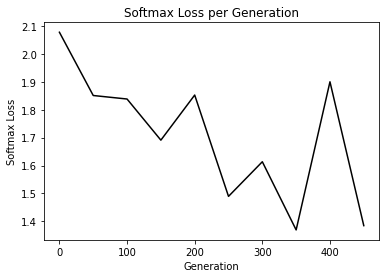

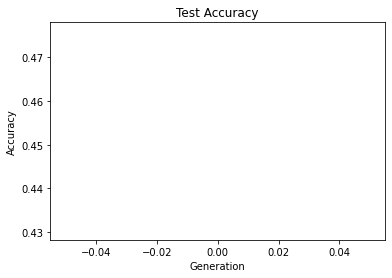

In [20]:

# Print loss and accuracy
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

# Plot loss over time
plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot accuracy over time
plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()

# model 2 

https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb

In [17]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


The label data is just a list of 10,000 numbers ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.

- airplane : 0
- automobile : 1
- bird : 2
- cat : 3
- deer : 4
- dog : 5
- frog : 6
- horse : 7
- ship : 8
- truck : 9

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [21]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
  
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None
    
    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
   
    for key, value in label_counts.items():
        print('Label Counts of [{}] ({}): {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0] (AIRPLANE): 994
Label Counts of [1] (AUTOMOBILE): 1042
Label Counts of [2] (BIRD): 965
Label Counts of [3] (CAT): 997
Label Counts of [4] (DEER): 990
Label Counts of [5] (DOG): 1029
Label Counts of [6] (FROG): 978
Label Counts of [7] (HORSE): 1015
Label Counts of [8] (SHIP): 961
Label Counts of [9] (TRUCK): 1029

Example of Image 700:
Image - Min Value: 8 Max Value: 250
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


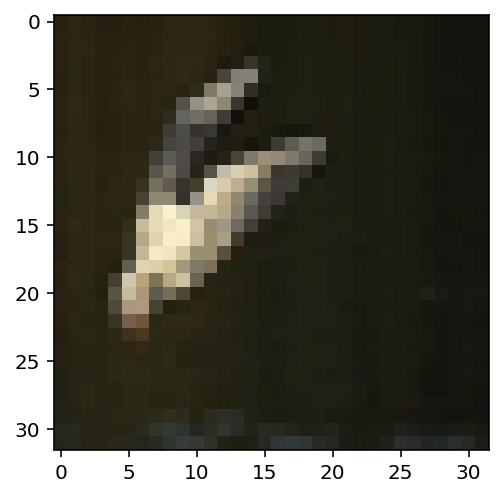

In [22]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 700
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [23]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [24]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [25]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    
    pickle.dump((features, labels), open(filename, 'wb'))
    
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)
        
        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')
        
        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])
    
    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')
    
    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels= batch['labels']
    
    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [26]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# checkpoint

In [27]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

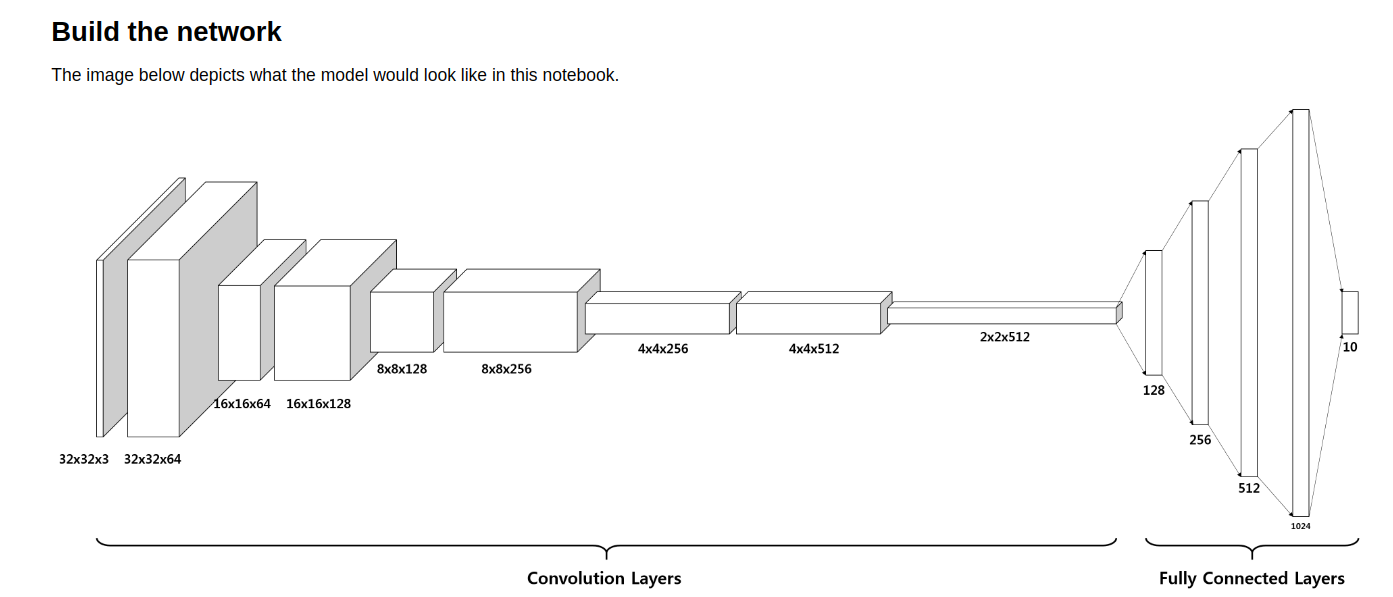

In [28]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name = 'input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name = 'output_y')

keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

Create Convolutional Model¶
The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
 - ReLU activation function
 - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
 - ReLU activation function
 - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
 - ReLU activation function
 - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
 - ReLU activation function
 - Batch Normalization
 
 
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
 - Dropout
 - Batch Normalization
11. Fully Connected Layer with 256 units
 - Dropout
 - Batch Normalization
12. Fully Connected Layer with 512 units
 - Dropout
 - Batch Normalization
13. Fully Connected Layer with 1024 units
 - Dropout
 - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

In [29]:
import tensorflow as tf

def conv_net(x, keep_prob):
    # [filter_height, filter_width, in_channels, out_channels]
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08)) 
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

In [30]:
epochs = 4
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [31]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross

# Single Optimization

In [32]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch,
                                      y: label_batch,
                                      keep_prob: keep_probability})

# Show Stats

In [33]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, feed_dict={x: feature_batch,
                                     y: label_batch,
                                     keep_prob: 1.
                                    })
    
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features,
                                              y: valid_labels,
                                              keep_prob: 1.
                                             })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

# Fully Train the Model

In [34]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [35]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1578 Validation Accuracy: 0.201200
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8260 Validation Accuracy: 0.296800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.5106 Validation Accuracy: 0.330400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5695 Validation Accuracy: 0.383200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3929 Validation Accuracy: 0.440200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3174 Validation Accuracy: 0.495800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1016 Validation Accuracy: 0.534400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0320 Validation Accuracy: 0.560400
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.9304 Validation Accuracy: 0.585400
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8179 Validation Accuracy: 0.618400
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.8275 Validation Accuracy: 0.637200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.7794 Validation Accuracy: 0.640000
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.4974 Validation Accuracy: 0.673400


# Test Model

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.685609076433121



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (5).

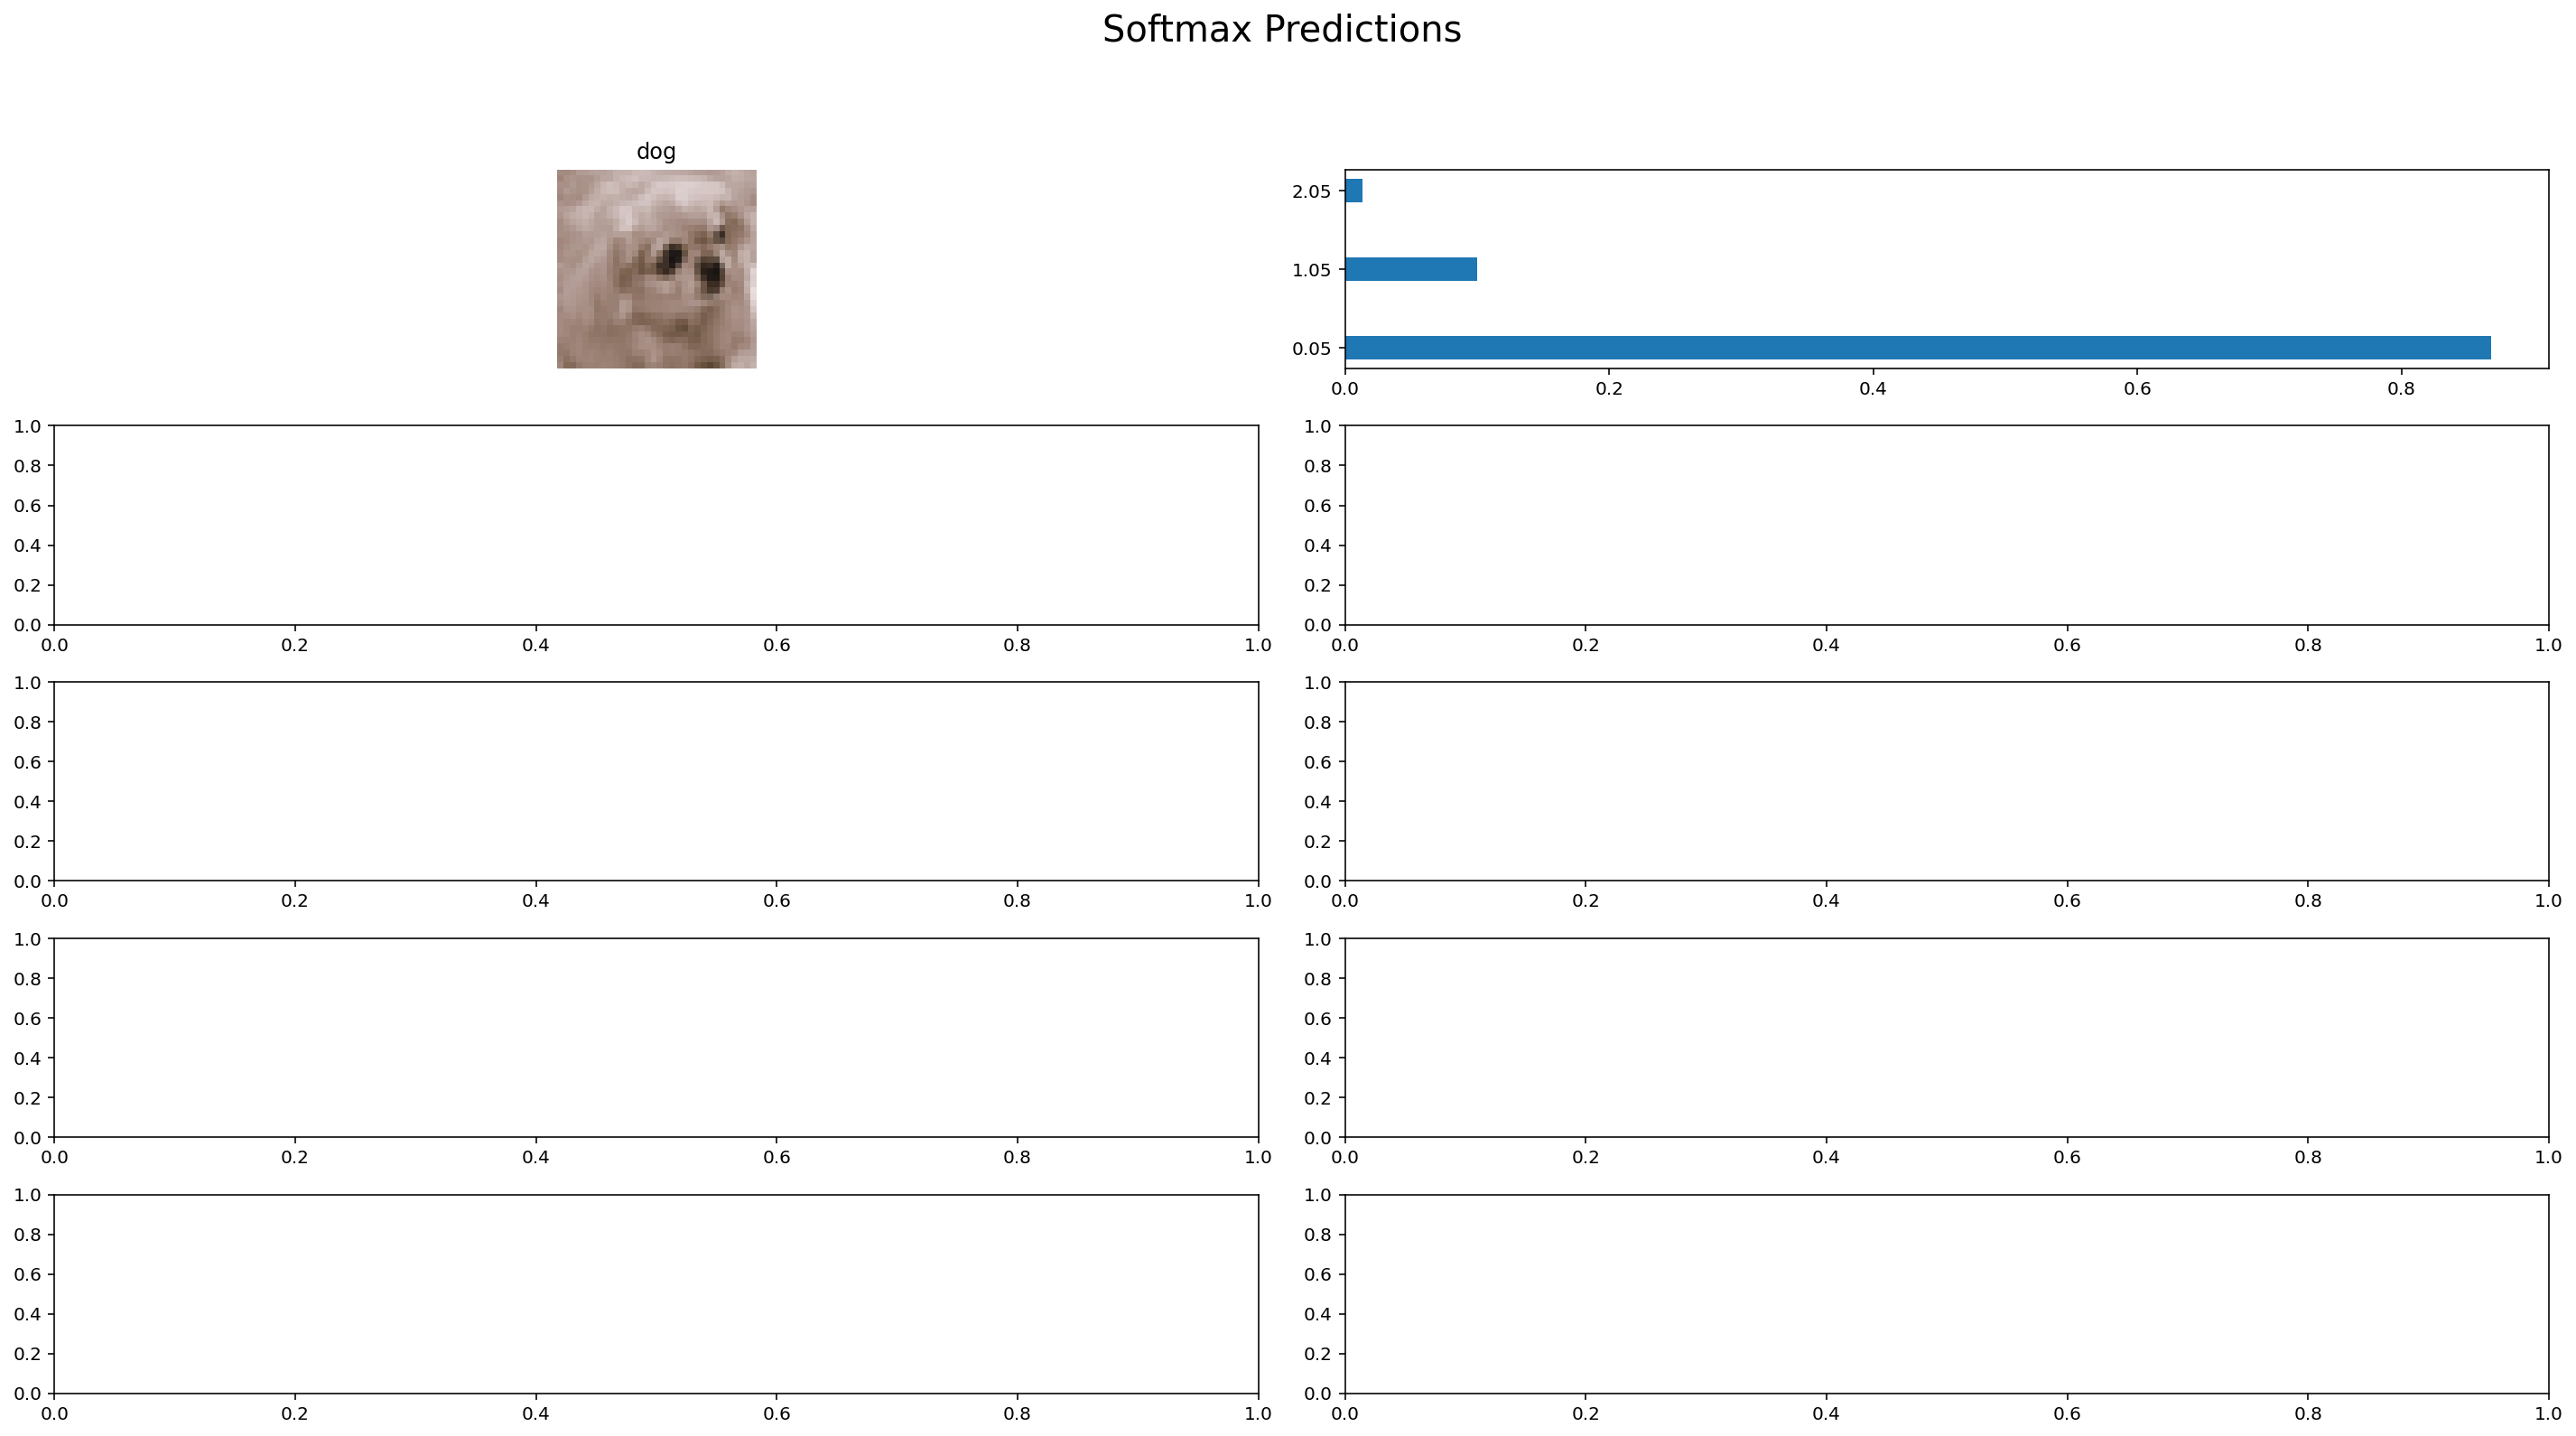

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()